In [1]:
import pymongo as pm
from pprint import pprint
from datetime import datetime
from matplotlib import pyplot as plt
import numpy as np
from geopy.distance import geodesic 

In [2]:
client = pm.MongoClient('bigdatadb.polito.it',
                        ssl=True,
                        authSource = 'carsharing',
                        tlsAllowInvalidCertificates=True)
db = client['carsharing']
db.authenticate('ictts', 'Ictts16!')

permanentBookings = db['PermanentBookings']


In [3]:
start = datetime.fromisoformat('2017-01-01')
end = datetime.fromisoformat('2017-02-28')
city = "Vancouver"
geo_range = [[(49.350849,-123.310688),(49.350849,-123.014714)],[(49.175794,-123.310688),(49.175794,-123.014714)]]

In [4]:
# select all parking in the time period
pipeline_parking_in_period = [{"$match": {"city": city}},
                        {"$match": {"$and": [{"init_date": {"$gte": start}}, {"final_date": {"$lte": end}}]}},
                        {"$project": {
                                    "_id": 1, 
                                    "origin":{"$arrayElemAt": [ "$origin_destination.coordinates", 0]},
                                    "destination":{"$arrayElemAt": [ "$origin_destination.coordinates", 1]},
                                    "duration": {"$divide": [{"$subtract": ["$final_time", "$init_time"]}, 60]},
                                    "moved": {"$ne": [{"$arrayElemAt": [ "$origin_destination.coordinates", 0]},
                                                        {"$arrayElemAt": [ "$origin_destination.coordinates", 1]}]},
                                    }
                        },
                        {"$match": {"$and": [   {"duration": {"$gte": 5}}, 
                                                {"duration": {"$lte": 3 * 60}},
                                                {"moved": True},
                                            ]
                        }}
                        ]


#pprint(pipeline_parking_in_period)

bookings = permanentBookings.aggregate(pipeline_parking_in_period)

In [5]:
# bookings.next()

In [5]:
longitude_range = geodesic(geo_range[0][0],geo_range[0][1]).m
latitude_range = geodesic(geo_range[0][0],geo_range[1][0]).m
print(longitude_range)
print(latitude_range)

longitude_blocks = int(longitude_range/500)
latitude_blocks = int(latitude_range/500)
longitude_step = (geo_range[0][1][1]-geo_range[0][0][1])/longitude_blocks
latitude_step= (geo_range[1][0][0]-geo_range[0][0][0])/latitude_blocks
print(longitude_step)
print(latitude_step)


block_map = np.zeros([latitude_blocks,longitude_blocks],dtype=int)
counter = 1 
for i in range(latitude_blocks):
    for j in range(longitude_blocks):
        block_map[i][j]=counter
        counter +=1

od_map ={}
reference_point = geo_range[0][0]
print_count =0
for booking in bookings:
    # if print_count>10:
    #     break
    # print_count+=1
    try:
        #find origin region
        longitude_bias = int(geodesic(reference_point,(reference_point[0],booking["origin"][0])).m/500)
        latitude_bias = int(geodesic(reference_point,(booking["origin"][1],reference_point[1])).m/500)
        origin = block_map[latitude_bias][longitude_bias]
        #print(origin)
        #find destination region
        longitude_bias = int(geodesic(reference_point,(reference_point[0],booking["destination"][0])).m/500)
        latitude_bias = int(geodesic(reference_point,(booking["destination"][1],reference_point[1])).m/500)
        destination = block_map[latitude_bias][longitude_bias]
        #print(destination)
        try:
            temp = od_map[(origin,destination)]
            temp +=1
            od_map[(origin,destination)] = temp
        except:
            od_map[(origin,destination)] =1
    except:
        continue

21504.410396889554
19468.713197564055
0.006883116279069792
-0.0046067105263156135


In [72]:
# find the regions that with O-D router booking>100 
filtered_key = []
for key in od_map.keys():
    if od_map[key]>=100:
       filtered_key.append(key)
print(len(filtered_key))

59


In [73]:
origins = set()
destinations = set()
for key in filtered_key:
    origins.add(key[0])
    destinations.add(key[1])
origins = list(origins)
origins.sort()
destinations = list(destinations)
destinations.sort()
print(len(origins))
print(len(destinations))

24
24


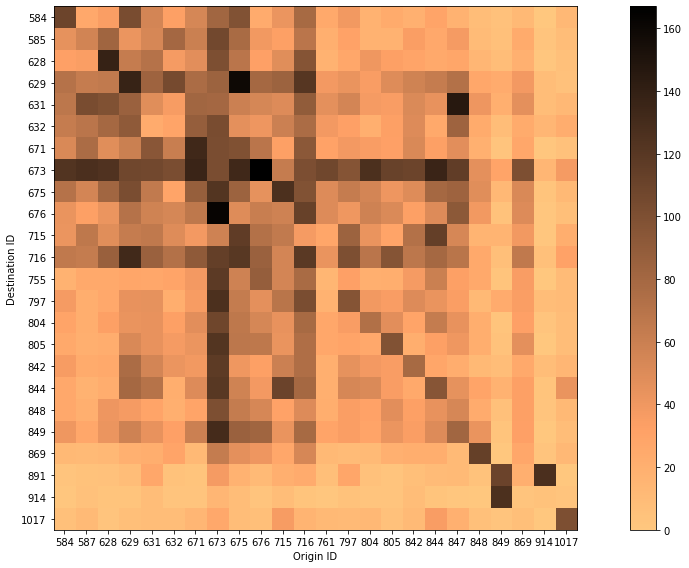

In [74]:
density = np.zeros([len(origins),len(destinations)],dtype=int)

for i in range(len(origins)):
    for j in range(len(destinations)):
        try:
            density[i][j] = od_map[(origins[i],destinations[j])]
        except:
            pass

plt.rcParams["figure.figsize"] = [15.00, 8.0]
plt.rcParams["figure.autolayout"] = True
im = plt.imshow(density, cmap="copper_r")
plt.colorbar(im)

temp_loc = 0
x = []
for elem in origins:
    x.append(temp_loc)
    temp_loc += 1
plt.xticks(x,origins)

temp_loc = 0
y = []
for elem in destinations:
    y.append(temp_loc)
    temp_loc += 1
plt.yticks(y,destinations)
plt.xlabel("Origin ID")
plt.ylabel("Destination ID")

plt.show()